In [126]:
import numpy as np
import pandas as pd
from sublimpy import utils, tidy
import altair as alt
alt.data_transformers.enable('json')
from scipy import interpolate

import swifter
import xarray as xr
import tqdm
import matplotlib.pyplot as plt
from metpy.units import units

import datetime as dt
from sklearn.metrics import r2_score
from metpy.units import units
import math 
import geopandas as gpd

In [127]:
HEIGHTS = [1,3,10]
HORIZ_GRID_SPACING = 50
VERT_GRID_SPACING = 20
# start_date = '20221130'
# end_date = '20230509'
start_date = '20221101'
end_date = '20230619'

# data_start_date = '20221130'
# data_cutoff_date = '20230508'

data_start_date = '20221107'
data_cutoff_date = '20230619'

## PARAMETERS FOR SOS DATA
# streamwise coordinates
# sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000.parquet"
sos_tidy_fn = f"../paper1/process_slow_data/tidy_df_20221101_20230619_planar_fit_multiplane_STRAIGHTUP_q7_flags9000_pf10.parquet"

## PARAMETERS FOR SPLASH DATA
# download dir
avp_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/"
kps_download_dir = "/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/"

ftp_url = 'ftp1.esrl.noaa.gov'
# Avery Picnic product
avp_url = f'Observations/Campaigns/SPLASH/asfs50/2_level_ingest/'
# Kettle Ponds product
kps_url = f'Observations/Campaigns/SPLASH/asfs30/2_level_ingest/'

# Open data

In [128]:

## SOS
tidy_df = pd.read_parquet(sos_tidy_fn)

# Convert data timezone to local and clean up data on the ends
# convert time column to datetime
tidy_df['time'] = pd.to_datetime(tidy_df['time'])
tidy_df = utils.modify_df_timezone(tidy_df, 'UTC', 'US/Mountain')
# limit data to our dates of interest, based on continuous snow cover at Kettle Ponds
tidy_df = tidy_df[tidy_df.time > data_start_date][tidy_df.time < data_cutoff_date]
tidy_df = tidy_df.set_index('time').sort_index().loc[data_start_date:data_cutoff_date].reset_index()

In [129]:

# Get the list of files in the directory
file_list = os.listdir(avp_download_dir)

# file_list = [f for f in file_list if 'sledmet.asfs50.level2.0.1min.' in f]
file_list = [f for f in file_list if 'sledmet.asfs50.level2.0.1min.' in f]

# Sort the file list
file_list.sort()

# Create an empty list to store the dataarrays
# mixingratio_dataarray_list = []
# abshum_dataarray_list = []
# snowdepth_list = []
temp_dataarray_list = []
# rh_dataarray_list = []
# w_dataarray_list = []
p_dataarray_list = []

# Iterate over each file with tqdm
for file_name in tqdm.tqdm(file_list):
    # Open the file using xarray
    dataset = xr.open_dataset(os.path.join(avp_download_dir, file_name))
    
    # Extract the dataarray for the variable 'mixing_ratio', Add the dataarray to the list
    # mixingratio_dataarray_list.append(dataset['mixing_ratio'])
    # abshum_dataarray_list.append(dataset['h2o_licor'])
    # snowdepth_list.append(dataset['snow_depth'])
    temp_dataarray_list.append(dataset['temp'])  # Add this line
    # rh_dataarray_list.append(dataset['rh'])  # Add this line
    # w_dataarray_list.append(dataset['wspd_w_mean'])  # Add this line
    p_dataarray_list.append(dataset['atmos_pressure'])

# mixingratio_ds = xr.concat(mixingratio_dataarray_list, dim='time')
# mixingratio_ds = utils.modify_xarray_timezone(mixingratio_ds, 'UTC', 'US/Mountain')
# abshum_ds = xr.concat(abshum_dataarray_list, dim='time')
# abshum_ds = utils.modify_xarray_timezone(abshum_ds, 'UTC', 'US/Mountain')
# annex_snowdepth_ds = xr.concat(snowdepth_list, dim='time')
# annex_snowdepth_ds = utils.modify_xarray_timezone(annex_snowdepth_ds, 'UTC', 'US/Mountain')
temp_ds = xr.concat(temp_dataarray_list, dim='time')
temp_ds = utils.modify_xarray_timezone(temp_ds, 'UTC', 'US/Mountain')
# rh_ds = xr.concat(rh_dataarray_list, dim='time')
# rh_ds = utils.modify_xarray_timezone(rh_ds, 'UTC', 'US/Mountain')
# w_ds = xr.concat(w_dataarray_list, dim='time')
# w_ds = utils.modify_xarray_timezone(w_ds, 'UTC', 'US/Mountain')
p_ds = xr.concat(p_dataarray_list, dim='time')
p_ds = utils.modify_xarray_timezone(p_ds, 'UTC', 'US/Mountain')

100%|██████████| 565/565 [00:28<00:00, 19.52it/s]


# Create categories

In [130]:
# Identify lists of timestamps for different categories
bs_times = set(
    tidy_df.query("variable == 'SF_avg_1m_ue'").query("value > 0").time
).union(
    set(tidy_df.query("variable == 'SF_avg_2m_ue'").query("value > 0").time)
)
nobs_times = set(tidy_df.time).difference(bs_times)

decoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value < 0.43").time
weaklycoupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value >= 0.43").query("value <= 0.61").time
coupled_times = tidy_df.query("variable == 'omega_3m_c'").query("value > 0.61").time

ri_stable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value > 0.25").time
ri_unstable_times = tidy_df.query("variable == 'Ri_3m_c'").query("value < -0.01").time
ri_neutral_times = tidy_df.query("variable == 'Ri_3m_c'").query("value >= -0.01").query("value <= 0.25").time

tgrad_stable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value > 0.01").time
tgrad_unstable_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value < -0.01").time
tgrad_neutral_times = tidy_df.query("variable == 'temp_gradient_3m_c'").query("value >= -0.01").query("value <= 0.01").time

upvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 152").query("value > 92").time.values
downvalley_wind_times = tidy_df[tidy_df.variable == 'dir_3m_c'].query("value < 342").query("value > 292").time.values

len(upvalley_wind_times),len(downvalley_wind_times)

(2031, 5441)

## Collect temperature data, in a vertical profile on tower c

In [131]:
## Isolate humidity measurements (from hygrometers)
temp_profile_df = tidy_df[tidy_df.measurement.isin(['temperature'])]
temp_profile_df.measurement = 'temperature'
temp_profile_df = temp_profile_df.pivot_table(
        index='time', columns=['height', 'tower', 'measurement'], values='value'
    )

# Combine with snow depth data
temp_profile_df = temp_profile_df.melt(ignore_index=False).join(
    tidy_df[tidy_df.variable == 'SnowDepth_c'].set_index('time')['value'].rename('snow depth')
)

# Calculate instrument height above snow surface
temp_profile_df['instrument_height'] = temp_profile_df['height'] - temp_profile_df['snow depth']

# Filter out measurements that are buried in the snow
temp_profile_df = temp_profile_df[
    (temp_profile_df['instrument_height'] > 0)
    | (temp_profile_df['height'] == 0)
]

temp_profile_df['instrument_height'] = temp_profile_df['instrument_height'].where(
    temp_profile_df['instrument_height'] > 0,
    0
)
temp_profile_df

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_57077/326702842.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_profile_df.measurement = 'temperature'


,height,tower,measurement,value,snow depth,instrument_height
time,,,,,,
2022-11-07 00:30:00,1.0,c,temperature,-2.611392,0.029834,0.970166
2022-11-07 01:00:00,1.0,c,temperature,-2.597149,0.030787,0.969213
2022-11-07 01:30:00,1.0,c,temperature,-2.584403,0.031069,0.968931
2022-11-07 02:00:00,1.0,c,temperature,-2.132004,0.031351,0.968649
2022-11-07 02:30:00,1.0,c,temperature,-2.389273,0.025319,0.974681
...,...,...,...,...,...,...
2023-06-18 21:30:00,20.0,c,temperature,12.956008,0.005173,19.994827
2023-06-18 22:00:00,20.0,c,temperature,11.053670,0.006668,19.993332
2023-06-18 22:30:00,20.0,c,temperature,11.217368,0.005557,19.994443


In [132]:
from sublimpy.gradients import LogPolynomialWithRoughness

def calculate_temp_gradient(
        one_ts_groupby,
        height4estimate,
        Z0Q = 0.005
    ):
    """ 
    Calculates mixing ratio gradient from a dataframe with datetimeindex,
    and columns `instrument_height`  and `value`, which holds mixing ratio
    values. These calculations are done by fitting log-polynomial curve to 
    measurements of z and X where X is some measured variable.
    We include a boundary wall condition, applying measured X at
    roughness height (T=T_s at z=z0). We also adjust for snow depth 
    in our calculations.
    """    
    heights = one_ts_groupby.sort_values('instrument_height')['instrument_height']
    values = one_ts_groupby.sort_values('instrument_height')['value']

    heights = heights.replace(0,Z0Q)

    # calculate fitted loglinear parameters
    params = LogPolynomialWithRoughness.fit_function(
        values,
        heights
    )
    values_pred = [
        LogPolynomialWithRoughness.function(z, params[0], params[1], params[2])
        for z in heights
    ]
    a = params[0]
    b = params[1]
    gradient = LogPolynomialWithRoughness.gradient_single_component(height4estimate, a, b)
    return gradient, a, b, heights, values, values_pred

Text(0, 0.5, 'height above snow(m)')

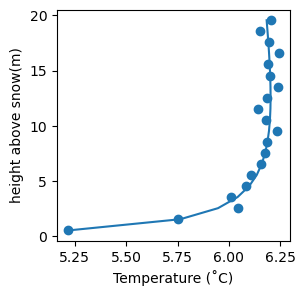

In [133]:
gradient, a, b, heights, values, values_pred =  calculate_temp_gradient(
    temp_profile_df.groupby('time').get_group('2023-05-05 12:30:00'),
    3   
)
c = values[0]
plt.figure(figsize=(3,3))
plt.plot(values_pred, heights)
plt.scatter(values, heights)

plt.xlabel('Temperature (˚C)')
plt.ylabel('height above snow(m)')

## Calculate $dT/dz$ and Vertical Advection for all timestamps

We calculate at the heights of the EC instruments.

In [134]:
def get_dT_dz_values_for_height(H):
    dT_dz = temp_profile_df.reset_index().swifter.groupby('time').apply(
        lambda df: calculate_temp_gradient(df, H)[
            :3 # drop the extra outputs
        ]
    )
    dT_dz = pd.DataFrame(dT_dz.tolist()).rename(columns={
        0: 'dT_dz',
        1: 'fit_param_a',
        2: 'fit_param_b',
        # 3: 'heights',
        # 4: 'values', 
        # 5: 'values_pred'
    }).assign(time = dT_dz.index).set_index('time')

    return dT_dz.drop_duplicates()

def add_variables_to_dT_dz_values(H, dT_dz_values, tidy_df_specific_pf):
    return dT_dz_values.join(
        tidy_df_specific_pf.query(f"variable == 'w_{H}m_c'").set_index('time')['value'].rename(f"w_{H}m_c")
    ).join(
        tidy_df_specific_pf.query(f"variable == 'w_tc__{H}m_c'").set_index('time')['value'].rename(f"w_tc__{H}m_c")
    )

def get_advection_df(H, tidy_df_specific_pf):
    df = get_dT_dz_values_for_height(H)
    df = add_variables_to_dT_dz_values(H, df, tidy_df_specific_pf) 
    df[f"vertical_advection_{H}m_c"] = df[f"w_{H}m_c"]*df["dT_dz"]
    return df.drop(columns = ['dT_dz', 'fit_param_a', 'fit_param_b'])

In [135]:
### 3 sector
dT_dz_values_for_height = {
    2:      get_advection_df(2,     tidy_df),
    3:      get_advection_df(3,     tidy_df),
    5:      get_advection_df(5,     tidy_df),
    10:     get_advection_df(10,    tidy_df),
    15:     get_advection_df(15,    tidy_df),
    20:     get_advection_df(20,    tidy_df),
}

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

In [136]:
from functools import reduce
adv_df = reduce(lambda  left,right: 
                   left.join(right), list(dT_dz_values_for_height.values())
)


## Calculate Flux Divergence

In [137]:
flux_divergence_df = tidy_df[tidy_df.variable.isin([
    'w_tc__3m_c',
    'w_tc__5m_c',
    'w_tc__10m_c',
    'w_tc__20m_c',
])].pivot(index='time', columns='variable', values='value')
flux_divergence_df['vertical_turb_flux_divergence_3to5'] = (
    flux_divergence_df['w_tc__5m_c'] - flux_divergence_df['w_tc__3m_c']
) / 2
flux_divergence_df['vertical_turb_flux_divergence_3to10'] = (
    flux_divergence_df['w_tc__10m_c'] - flux_divergence_df['w_tc__3m_c']
) / 7
flux_divergence_df['vertical_turb_flux_divergence_3to20'] = (
    flux_divergence_df['w_tc__20m_c'] - flux_divergence_df['w_tc__3m_c']
) / 17
flux_divergence_df = flux_divergence_df.drop(columns=['w_tc__3m_c', 'w_tc__5m_c', 'w_tc__10m_c', 'w_tc__20m_c',])

In [138]:
adv_df = adv_df.join(
    flux_divergence_df
)

### Add w measurements

## Calculate storage change term

In [139]:
timestep = 1800 # seconds
storage_change_2m = temp_profile_df.query("height <= 2").groupby('time')['value'].mean().rename('storage_change_2m').diff()/timestep
storage_change_3m = temp_profile_df.query("height <= 3").groupby('time')['value'].mean().rename('storage_change_3m').diff()/timestep
storage_change_5m = temp_profile_df.query("height <= 5").groupby('time')['value'].mean().rename('storage_change_5m').diff()/timestep
storage_change_10m = temp_profile_df.query("height <= 10").groupby('time')['value'].mean().rename('storage_change_10m').diff()/timestep
storage_change_15m = temp_profile_df.query("height <= 15").groupby('time')['value'].mean().rename('storage_change_15m').diff()/timestep
storage_change_20m = temp_profile_df.query("height <= 20").groupby('time')['value'].mean().rename('storage_change_20m').diff()/timestep

In [140]:
adv_df = adv_df.join(storage_change_2m).join(
    storage_change_3m
).join(
    storage_change_5m
).join(
    storage_change_10m
).join(
    storage_change_15m
).join(
    storage_change_20m
)

## Calculate horizontal advection

In [141]:
from metpy.calc import potential_temperature

In [142]:
kps_t_series = tidy_df.query("variable == 'T_10m_c'").set_index('time').value
kps_p_series = tidy_df.query("variable == 'P_10m_c'").set_index('time').value
avp_t_series = temp_ds.to_dataframe().resample('30min')['temp'].mean().rename('avp_T_3m')
avp_p_series = p_ds.to_dataframe().resample('30min')['atmos_pressure'].mean().rename('avp_P_3m')

In [143]:
kps_tpot_series = pd.Series(
    potential_temperature(kps_p_series.values * units("millibar"), kps_t_series.values * units('celsius')).magnitude,
    index = kps_p_series.index
).rename('kps_tpot_3m')
avp_tpot_series = pd.Series(
    potential_temperature(avp_p_series.values * units("millibar"), avp_t_series.values * units('celsius')).magnitude,
    index = avp_p_series.index
).rename('avp_tpot_3m')

In [144]:
horiz_adv_df = pd.DataFrame(kps_tpot_series).join(avp_tpot_series)
# Downvalley is positive X direction
DELTA_X = 2500 #m
horiz_adv_df['delta_T_delta_x'] = ( horiz_adv_df['kps_tpot_3m'] - horiz_adv_df['avp_tpot_3m'] ) / DELTA_X

# Get wind speed values
horiz_adv_df = horiz_adv_df.join(
    tidy_df.query("variable == 'spd_3m_c'").set_index('time')['value'].rename('U')
)

# Only include downvalley and upvalley wind directions and ensure U is positive/negative
# for downvalley/upvalley
horiz_adv_df_downvalley = horiz_adv_df[horiz_adv_df.index.isin(downvalley_wind_times)]
horiz_adv_df_upvalley = horiz_adv_df[horiz_adv_df.index.isin(upvalley_wind_times)]
horiz_adv_df_upvalley['U'] = - horiz_adv_df_upvalley['U']
horiz_adv_df = pd.concat([horiz_adv_df_downvalley, horiz_adv_df_upvalley]).sort_index()
horiz_adv_df['horizontal_advection'] = horiz_adv_df['delta_T_delta_x'] * horiz_adv_df['U']

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_57077/4081875053.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  horiz_adv_df_upvalley['U'] = - horiz_adv_df_upvalley['U']


In [145]:
adv_df = adv_df.join(
    horiz_adv_df[['horizontal_advection', 'delta_T_delta_x']]
)

# Plot

In [146]:
nobs_dovalley_times = nobs_times.intersection(set(pd.to_datetime(downvalley_wind_times)))
nobs_upvalley_times = nobs_times.intersection(set(pd.to_datetime(upvalley_wind_times)))
len(nobs_dovalley_times), len(nobs_upvalley_times)

(4505, 1656)

## Transport terms - flux densities, w/ vertical advection

In [147]:
def plot(src):
    fluxdiv_chart = alt.Chart(
        src.rename(columns={
        'vertical_turb_flux_divergence_3to20': 'flux_div_3to20',
        'vertical_turb_flux_divergence_3to10': 'flux_div_3to10',
        'vertical_turb_flux_divergence_3to5': 'flux_div_3to5',
    })
    ).transform_fold([
        'flux_div_3to5', 'flux_div_3to10', 'flux_div_3to20', 
    ]).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.StrokeDash('key:O'),
    ).properties(width=200, height=125) 
    advection_chart = alt.Chart(
        src[[
            'vertical_advection_2m_c', 
            'vertical_advection_3m_c', 
            'vertical_advection_5m_c', 
            'vertical_advection_10m_c', 
            'vertical_advection_15m_c', 
            'vertical_advection_20m_c',
            'time'
        ]].rename(columns = {
            'vertical_advection_2m_c': '2',
            'vertical_advection_3m_c': '3',
            'vertical_advection_5m_c': '5',
            'vertical_advection_10m_c': '10',
            'vertical_advection_15m_c': '15',
            'vertical_advection_20m_c': '20',
        })
    ).transform_fold([
        '2', '3', '5', '10', '15', '20',
    ]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.Color('key:O').scale(scheme='rainbow').title(['W ∂T/∂z', '@ height (m)']).sort([
            '2', '3', '5', '10', '15', '20',
        ]),
    ).properties(width=200, height=125)

    return (
        advection_chart+
        fluxdiv_chart
    ).resolve_scale(color='independent')

In [148]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


alt.HConcatChart(...)

In [169]:
def plot(src):
    fluxdiv_chart = alt.Chart(
        src.rename(columns={
        'vertical_turb_flux_divergence_3to20': 'flux_div_3to20',
        'vertical_turb_flux_divergence_3to10': 'flux_div_3to10',
        'vertical_turb_flux_divergence_3to5': 'flux_div_3to5',
    })
    ).transform_fold([
        'flux_div_3to5', 'flux_div_3to10', 'flux_div_3to20', 
    ]).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.StrokeDash('key:O'),
    ).properties(width=200, height=125) 
    advection_chart = alt.Chart(
        src[['horizontal_advection', 'time']]
    ).transform_fold(['horizontal_advection']).mark_line(color='red').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(horizontal_advection):Q'),
        alt.Color('key:O').scale(range=['red']),
    ).properties(width=200, height=125)

    return (
        advection_chart+
        fluxdiv_chart
    ).resolve_scale(color='independent')

In [170]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


alt.HConcatChart(...)

## Fluxes - w/ corrections

In [149]:
adv_df['w_tc__2m_c_corrected'] = adv_df['w_tc__2m_c'] + 2*adv_df['vertical_advection_2m_c']
adv_df['w_tc__3m_c_corrected'] = (
    adv_df['w_tc__3m_c'] + 2*adv_df['vertical_advection_2m_c'] + 1*adv_df['vertical_advection_3m_c']
)
adv_df['w_tc__5m_c_corrected'] = (
    adv_df['w_tc__5m_c'] + 2*adv_df['vertical_advection_2m_c'] + 2*adv_df['vertical_advection_3m_c'] + 1*adv_df['vertical_advection_5m_c']
)
adv_df['w_tc__10m_c_corrected'] = (
    adv_df['w_tc__10m_c'] + 2*adv_df['vertical_advection_2m_c'] + 2*adv_df['vertical_advection_3m_c'] + 3.5*adv_df['vertical_advection_5m_c'] 
    + 2.5*adv_df['vertical_advection_10m_c']
)
adv_df['w_tc__15m_c_corrected'] = (
    adv_df['w_tc__15m_c'] + 2*adv_df['vertical_advection_2m_c'] + 2*adv_df['vertical_advection_3m_c'] + 3.5*adv_df['vertical_advection_5m_c'] 
    + 5*adv_df['vertical_advection_10m_c'] + 2.5*adv_df['vertical_advection_15m_c']
)
adv_df['w_tc__20m_c_corrected'] = (
    adv_df['w_tc__20m_c'] + 2*adv_df['vertical_advection_2m_c'] + 2*adv_df['vertical_advection_3m_c'] + 3.5*adv_df['vertical_advection_5m_c'] 
    + 5*adv_df['vertical_advection_10m_c'] + 5*adv_df['vertical_advection_15m_c'] + 2.5*adv_df['vertical_advection_20m_c']
)

In [172]:
src = adv_df[[
    'w_tc__2m_c',
    'w_tc__3m_c',
    'w_tc__5m_c',
    'w_tc__10m_c',
    'w_tc__15m_c',
    'w_tc__20m_c',    
    'w_tc__2m_c_corrected',
    'w_tc__3m_c_corrected',
    'w_tc__5m_c_corrected',
    'w_tc__10m_c_corrected',
    'w_tc__15m_c_corrected',
    'w_tc__20m_c_corrected',    
]].drop_duplicates().sort_index()
src = src.loc['20221130': '20230508']
src = src.melt(ignore_index=False)
src['height'] = src['variable'].apply(lambda s: int(s.split('__')[1].split('m_c')[0]))
src['measurement'] = src['variable'].apply(lambda s: s.split('_')[-1])
src['measurement'] = src['measurement'].replace({'c': 'raw'})
src = src.reset_index()

In [173]:
def plot(src):
    return alt.Chart(
        src.reset_index()
    ).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q').
        alt.Facet('height:O', columns=1, spacing=0).header(labelPadding=-15, labelFontStyle='bold', labelFontSize=12, labelAnchor='end'),
        # alt.Color('height:O').scale(scheme='rainbow'),
        alt.StrokeDash('measurement:N')
    ).properties(width=200, height=75)

(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


alt.HConcatChart(...)

In [175]:
from metpy.units import units
def w_tc_to_watts(values):
    specific_heat_capacity_air = 1.0005 * units('kilojoules/(K*kg)')
    air_density = 1 * units("kg/m^3")
    sensible_heat_flux_meas_units = values * units("K*m/s")
    return (sensible_heat_flux_meas_units * specific_heat_capacity_air * air_density).to("W/m^2").magnitude
src['value_watts'] = w_tc_to_watts(src['value'].values)
src

,time,variable,value,height,measurement,value_watts
0,2022-11-30 00:00:00,w_tc__2m_c,-0.012374,2,raw,-12.379963
1,2022-11-30 00:30:00,w_tc__2m_c,-0.009808,2,raw,-9.812590
2,2022-11-30 01:00:00,w_tc__2m_c,-0.011078,2,raw,-11.083406
3,2022-11-30 01:30:00,w_tc__2m_c,-0.011418,2,raw,-11.423865
4,2022-11-30 02:00:00,w_tc__2m_c,-0.010239,2,raw,-10.244185
...,...,...,...,...,...,...
91879,2023-05-08 21:30:00,w_tc__20m_c_corrected,-0.259119,20,corrected,-259.248985
91880,2023-05-08 22:00:00,w_tc__20m_c_corrected,0.037873,20,corrected,37.891791
91881,2023-05-08 22:30:00,w_tc__20m_c_corrected,0.019441,20,corrected,19.450974
91882,2023-05-08 23:00:00,w_tc__20m_c_corrected,0.031222,20,corrected,31.237429


In [202]:
def plot(src):
    return alt.Chart(
        src.reset_index()
    ).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value_watts):Q').title('Hₛ (W/m²)'),
        alt.Facet('height:O', columns=1, spacing=0).header(labelPadding=-15, labelFontStyle='bold', labelFontSize=12, labelAnchor='end', titleFontSize=0),
        # alt.Color('height:O').scale(scheme='rainbow'),
        alt.StrokeDash('measurement:N')
    ).properties(width=200, height=75)

(
    plot(src[src.time.isin(nobs_upvalley_times)]).properties(title = 'upvalley winds')
    | 
    plot(src[src.time.isin(nobs_dovalley_times)]).properties(title = 'downvalley winds')
).resolve_scale(color='independent', x='shared', y='shared').properties(
    title = ['Seasonal composites of sensible heat flux (raw) with',
    'vertical advection correction applied (corrected) at multiple heights']
)

alt.HConcatChart(...)

## Storage change terms

In [154]:
def plot(src):
    fluxdiv_chart = alt.Chart(
        src.rename(columns={
        'vertical_turb_flux_divergence_3to20': 'flux_div_3to20',
        'vertical_turb_flux_divergence_3to10': 'flux_div_3to10',
        'vertical_turb_flux_divergence_3to5': 'flux_div_3to5',
    })
    ).transform_fold([
        'flux_div_3to5', 'flux_div_3to10', 'flux_div_3to20', 
    ]).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.StrokeDash('key:O'),
    ).properties(width=200, height=125) 
    advection_chart = alt.Chart(
        src[[
            'storage_change_2m', 
            'storage_change_3m', 
            'storage_change_5m', 
            'storage_change_10m', 
            'storage_change_15m', 
            'storage_change_20m',
            'time'
        ]].rename(columns = {
            'storage_change_2m': '2',
            'storage_change_3m': '3',
            'storage_change_5m': '5',
            'storage_change_10m': '10',
            'storage_change_15m': '15',
            'storage_change_20m': '20',
        })
    ).transform_fold([
        '2', '3', '5', '10', '15', '20',
    ]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.Color('key:O').scale(scheme='rainbow').title(['W ∂T/∂z', '@ height (m)']).sort([
            '2', '3', '5', '10', '15', '20',
        ]),
    ).properties(width=200, height=125)

    return (
        advection_chart+
        fluxdiv_chart
    ).resolve_scale(color='independent')

In [155]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


alt.HConcatChart(...)

## Horizontal advection terms

In [156]:
def plot(src):
    fluxdiv_chart = alt.Chart(
        src.rename(columns={
        'vertical_turb_flux_divergence_3to20': 'flux_div_3to20',
        'vertical_turb_flux_divergence_3to10': 'flux_div_3to10',
        'vertical_turb_flux_divergence_3to5': 'flux_div_3to5',
    })
    ).transform_fold([
        'flux_div_3to5', 'flux_div_3to10', 'flux_div_3to20', 
    ]).mark_line(color='black').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.StrokeDash('key:O'),
    ).properties(width=200, height=125) 
    advection_chart = alt.Chart(
        src[['horizontal_advection', 'time']]
    ).transform_fold(['horizontal_advection']).mark_line(color='red').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(horizontal_advection):Q'),
        alt.Color('key:O').scale(range=['red']),
    ).properties(width=200, height=125)

    return (
        advection_chart+
        fluxdiv_chart
    ).resolve_scale(color='independent')

In [157]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


alt.HConcatChart(...)

In [159]:
def plot(src):
    return alt.Chart(
        src[['delta_T_delta_x', 'time']]
    ).transform_fold(['delta_T_delta_x']).mark_line(color='red').encode(
        alt.X('hours(time):T'),
        alt.Y('mean(delta_T_delta_x):Q'),
        alt.Color('key:O').scale(range=['red']),
    ).properties(width=200, height=125)

In [160]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


alt.HConcatChart(...)

## W

In [114]:
def plot(src):
    return alt.Chart(
        src[[
            'w_2m_c', 
            'w_3m_c', 
            'w_5m_c', 
            'w_10m_c', 
            'w_15m_c', 
            'w_20m_c',
            'time'
        ]].rename(columns = {
            'w_2m_c': '2',
            'w_3m_c': '3',
            'w_5m_c': '5',
            'w_10m_c': '10',
            'w_15m_c': '15',
            'w_20m_c': '20',
        })
    ).transform_fold([
        '2', '3', '5', '10', '15', '20',
    ]).mark_line().encode(
        alt.X('hours(time):T'),
        alt.Y('mean(value):Q'),
        alt.Color('key:O').scale(scheme='rainbow').title(['W ∂T/∂z', '@ height (m)']).sort([
            '2', '3', '5', '10', '15', '20',
        ]),
    ).properties(width=200, height=125)

In [115]:
src = adv_df.drop_duplicates().sort_index()
src = src.loc['20221130': '20230508'].reset_index()
(
    plot(src[src.time.isin(nobs_upvalley_times)]) | plot(src[src.time.isin(nobs_dovalley_times)])
).resolve_scale(color='independent', x='shared', y='shared')


alt.HConcatChart(...)

In [124]:
src = tidy_df.query("tower == 'c'").query("measurement == 'wind direction'")
src = src[(src.time > '20221101') & (src.time < '20221115')]
src.value = src.value.apply(lambda x: x if x > 50 else x+360)
src = src[src.height.isin([2,5,10,20])]
alt.Chart(src).mark_line().encode(
    alt.X('time:T'),
    alt.Y('value:Q'),
    alt.Color('height:O').scale(scheme='rainbow')
).properties(width=800).interactive()

alt.Chart(...)